<a href="https://colab.research.google.com/github/gabrielvinicios02/ExperimentsMultivariate/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 225, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 225, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 225, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 225, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

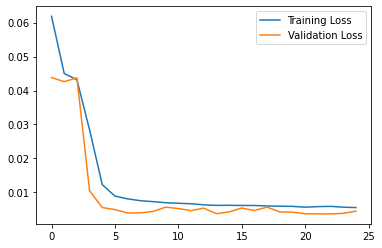

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


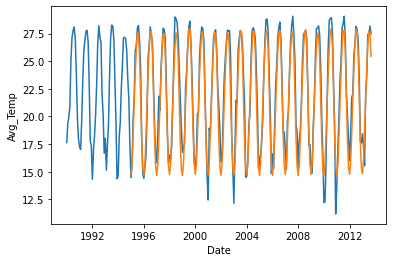

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
# Load Data
florida = pd.read_csv('../content/sample_data/florida_file_.csv')
florida.head()
florida.tail(5)
florida["Date"] = pd.to_datetime(florida["Date"])

florida = florida[["Date", "Avg_Temp"]]
florida = florida.fillna(florida.bfill())
florida.columns = ['Date', 'Avg_Temp']

train = florida[:-225]
len(train)
test = florida[-225:]
len(test)
train_dates = pd.to_datetime(train['Date'])
test_dates  = pd.to_datetime(test['Date'])

In [ ]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['Avg_Temp'].values.reshape(-1,1))

prediction_days = 225

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Build The Model
model = Sequential()

model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units =128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Prediction of the next value

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(x_train, y_train, epochs = 25, batch_size=32, validation_split=0.1)


plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()


In [ ]:
### Test the Model Accuracy on Existing Data ###
################################################
# take Test data Again
test.head()
actual_temp = test['Avg_Temp'].values
total_temp = pd.concat((train['Avg_Temp'], test['Avg_Temp']),axis=0)

model_inputs = total_temp[len(total_temp)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(test['Avg_Temp'], pred)

In [ ]:
### Visualization ###
#####################
pred_ = pd.DataFrame(test['Date'])
pred_['Avg_Temp'] = pred
pred_["Date"] = pd.to_datetime(pred_["Date"])

pred_
original = florida.loc[florida['Date'] >= '1990-01-01']

import seaborn as sns
sns.lineplot(original['Date'], original['Avg_Temp'])
sns.lineplot(pred_['Date'], pred_['Avg_Temp'])
plt.show()